# Assignment: Unsupervised Machine Learning \ Genetic Algorithms

In this assignment you will experience with Genetic Algorithms (GAs), starting from a basic implementation, continuing with dedicated improvements, and later applying it in various unsupervised machine learning scenarios.

## Part 1: Time Series of 'Likes' Influenced by Personalization

Various personalization algorithms are applied in e-commerce and other kinds of websites/apps in order to increase purchases or user engagement.

The following time series were collected over a period of 20 months from a large online retail store. In this study, during the first 10 months (normalized as the period from month -10 to month 0) a contextual personalization algorithm was applied in order to increase user engagement (measured as the accumulated number of 'Likes' on products shared via Facebook). As in the case with many contextual approaches, this algorithm suffered from the 'filter bubble' problem (https://en.wikipedia.org/wiki/Filter_bubble), and therefore reached a plateau quite quickly.

Nonetheless, this step enabled a more advanced collaborative filtering algorithm to analyze the collected data, learn, and increase user engagement once it was applied in the following 10 months. A classic inflection point was detected after the transition to the new algorithm. A domain expert envisioned the inflection dynamics will behave similarly to the formula f(x) = ax^3 + bx^2 + cx + d. The values of a, b, c and d were found to be 4.8, 12.1, 53.2 and 6219, respectively.

<< Please note: This function is an analytical solution, used here for simplifying the actual study, where a dynamic model was created with ODEs >>

We are given a sample sparse data of users from 10 different European countries. In this project, we will implement a simple GA in order to fit our data to the above-mentioned function, and discover the parameters for a, b, c and d. 

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read measured data from an Excel file

In [0]:
xlsx = pd.ExcelFile('European Measurements.xlsx')
sheet1 = xlsx.parse(3) # Note the other datasets in the file.
variables = ["Month","Avg. Likes"]
data = sheet1.loc[:, variables].values
print(data)

[[-9.70000000e+00  1.93303385e+03]
 [-9.10000000e+00  3.07678202e+03]
 [-7.70000000e+00  4.61959427e+03]
 [-7.30000000e+00  4.87640388e+03]
 [-7.20000000e+00  5.27621777e+03]
 [-6.20000000e+00  5.76967851e+03]
 [-4.70000000e+00  5.26728526e+03]
 [-4.10000000e+00  6.40777934e+03]
 [-3.30000000e+00  6.05631612e+03]
 [-2.70000000e+00  6.10216500e+03]
 [-2.50000000e+00  5.18359545e+03]
 [-2.30000000e+00  7.03041233e+03]
 [-1.90000000e+00  5.69790109e+03]
 [-1.80000000e+00  5.42920417e+03]
 [-1.20000000e+00  5.23662184e+03]
 [-9.00000000e-01  6.28278124e+03]
 [-1.00000000e-01  6.53285159e+03]
 [ 2.00000000e-01  5.78284515e+03]
 [ 3.00000000e-01  6.57445814e+03]
 [ 4.00000000e-01  5.25761264e+03]
 [ 1.10000000e+00  5.86568880e+03]
 [ 1.50000000e+00  6.92127198e+03]
 [ 1.60000000e+00  6.15982519e+03]
 [ 2.10000000e+00  6.87265063e+03]
 [ 2.20000000e+00  5.57408399e+03]
 [ 2.50000000e+00  5.88485867e+03]
 [ 5.20000000e+00  6.75130936e+03]
 [ 5.40000000e+00  7.32399792e+03]
 [ 5.90000000e+00  7

### Simple GA mechanism

In [0]:
def fitness_function(data, pop):
    fitness = []
    for solution in range(len(pop)):
        for event in range(len(data)):
            error = 0;
            event_time = data[event][0]
            event_measured = data[event][1]
            event_expected = pop[solution][0]*event_time**3 + pop[solution][1]*event_time**2 + pop[solution][2]*event_time + pop[solution][3]
            error +=(event_expected - event_measured)**2
        fitness.append(1/error) # We use 1/error in order to use a maximization mechanism, while we want to minimize the error
    return np.array(fitness)

def biased_selection(pop, fitness, num_parents):
    sorted_fitness_args = np.argsort(fitness)
    return pop[sorted_fitness_args[-num_parents:],:]
    # parents = np.empty((num_parents, pop.shape[1]))
    # for parent_num in range(num_parents):
    #     max_fitness_idx = np.where(fitness == np.max(fitness))
    #     max_fitness_idx = max_fitness_idx[0][0]
    #     parents[parent_num, :] = pop[max_fitness_idx, :]
    #     fitness[max_fitness_idx] = -99999999999
    # return parents

def recombination(parents, offspring_size):
    offspring = np.empty(offspring_size)
    recombination_point = np.uint8(offspring_size[1]/2)
    for k in range(offspring_size[0]):
        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]
        offspring[k, 0:recombination_point] = parents[parent1_idx, 0:recombination_point]
        offspring[k, recombination_point:] = parents[parent2_idx, recombination_point:]
    return offspring

def mutation(offspring_recombination):
    for idx in range(offspring_recombination.shape[0]):
        random_value = np.random.randint(-100, 100, 1)
        random_index = np.random.randint(0,offspring_recombination.shape[1],1)
        offspring_recombination[idx, random_index] = offspring_recombination[idx, random_index] + random_value
    return offspring_recombination


### GA application for fitting time series data

In [0]:
# GA Parameters
formula_degree = 4
number_of_solutions = 500
number_of_parents = 250
population_size = (number_of_solutions,formula_degree) 
number_of_generations = 200
best_outputs = []

# Genesis
np.random.seed(87)
new_population = np.random.randint(low=0, high=10000, size=population_size)

#stopping criteria
NUM_CRITERIA = 50
NUM_ITER = 15

past_fitness = np.zeros(NUM_CRITERIA)
counter = 0

print("The population of the first generation: ")
print(new_population)

# Evolution
print ("\nEvolution:")
for generation in range(number_of_generations):

    fitness = fitness_function(data, new_population)
    print("Generation = ", generation, "\tBest fitness = ", round(1/np.max(fitness),5))
    # best_outputs.append(np.max(np.sum(new_population*formula_degree, axis=1)))
    best_outputs.append(round(1/np.max(fitness),5))
    parents = biased_selection(new_population, fitness, number_of_parents, replace=False)
    offspring_recombination = recombination(parents, offspring_size=(population_size[0]-parents.shape[0], formula_degree))
    offspring_mutation = mutation(offspring_recombination,perc_child=0.5,frac_feat=2)
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation
    
    ## Stopping Criteria
    current_fitness = np.partition(fitness,kth=len(fitness)-NUM_CRITERIA)[-NUM_CRITERIA:]
    #If for NUM_ITER generations, the top NUM_CRITERIA best population don't change, we sterilize the parents.
    if (set(current_fitness).intersection(past_fitness) == set(current_fitness)):
        counter +=1
        if counter == NUM_ITER:
            print("We have reached our stopping criterion")
            break
    else:
        past_fitness = current_fitness
        counter = 0

# Results
print("\nThe population of the last generation: ")
print(new_population)
fitness = fitness_function(data, new_population)
best_match_idx = np.where(fitness == np.max(fitness))[0][0]
print("Best solution: ", new_population[best_match_idx, :])

# Chart
plt.plot(best_outputs)
plt.xlabel("Generation")
plt.ylabel("Best Fitness Score")
plt.show()

The population of the first generation: 
[[8525  143 5371 5126]
 [1926 2867 9737 4668]
 [2272 8253 3182 1224]
 ...
 [9356 9521  952 4238]
 [5094 6961 1533 9442]
 [3145 7646 4767 2807]]

Evolution:
Generation =  0 	Best fitness =  8991362233.57876


TypeError: biased_selection() got an unexpected keyword argument 'replace'

## Challenge 231
Implement a new and improved GA, based on the one above, by taking the following actions:

1. Make the bias_selection function give more chances to solutions with better fitness values, but not necesseraly take the best ones, as currently done.
2. Make the recombination function make real random recombination along the chromosome and between chromosomes
3. Change the mutation rate and/or scale to better avoid local minima while keeping evolution time short
4. Apply a smarter stopping criterion
5. Consider different GA parameters in order to reach better results

In [0]:
#Make the bias_selection function give more chances to solutions with better fitness values, but not necesseraly take the best ones, as currently done.
def biased_selection(pop, fitness, num_parents, replace=False):
    choices = np.random.choice(pop.shape[0],size=num_parents,replace=replace,p=fitness/np.sum(fitness))
    return pop[choices,:]

#Make the recombination function make real random recombination along the chromosome and between chromosomes
def recombination(parents, offspring_size):
    '''
    For every single new child (tu tu tu - bli ayin hara), we randomly decide:
    1) How many features to take from each parent
    2) Which features are actually taken.
    '''
    offspring = np.empty(offspring_size)
    
    num_features = parents.shape[1]
    num_pop = parents.shape[0]
    
    for k in range(offspring_size[0]):
        
        #First need to randomly decide how percentage to take from 1st parent.
        p1_num_features = np.random.randint(1,num_features)
        #Randomly decide which of the features to take
        p1_chrom = np.random.choice(num_features,size=p1_num_features,replace=False)
        p2_chrom = list(set(range(num_features)).difference(set(p1_chrom)))
        
        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]
        
        offspring[k, p1_chrom] = parents[parent1_idx, p1_chrom]
        offspring[k, p2_chrom] = parents[parent2_idx, p2_chrom]
    
    return offspring

#Change the mutation rate and/or scale to better avoid local minima while keeping evolution time short
def mutation(offspring_recombination, perc_child = 0.2, frac_feat = 1 ):
    '''
    perc_child - percentange of offspring that will have random mutation - float value between [0,1]
    frac_feat - fraction of max features that we will mutate - integer value [1,num_features], frac_feat = 2 means only 1/2 the features.
    '''
    #We don't want to mutate every child, only perc_feat%
    choices = np.random.choice(offspring_recombination.shape[0],size=int(np.round(offspring_recombination.shape[0]* perc_child)))
  
    for idx in choices:
        #Get a random number of features to change
        rand_features = np.random.randint(0,offspring_recombination.shape[1]//frac_feat + 1)
        rand_index = np.random.choice(offspring_recombination.shape[1],size=rand_features,replace=False)
        #We gonna spice up them randomness
        random_value = np.random.randint(-200, 200, rand_features)
        offspring_recombination[idx, rand_index] = offspring_recombination[idx, rand_index] + random_value
    return offspring_recombination

## Part 2: Solving Different Problems With the Same GA

Below is a reminder of the K-Means algorithm you implemented in Assignment 21X.

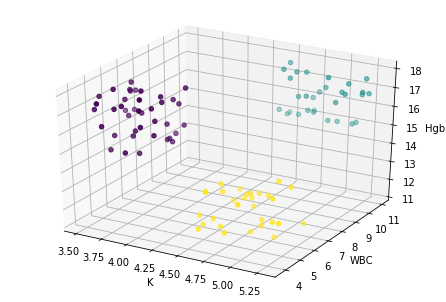

In [0]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

xlsx = pd.ExcelFile('EMR-Blood.xlsx')
sheet1 = xlsx.parse(0)
sheet1.set_index("Key", inplace=True)

variables1 = ["K","WBC","Hgb"]
EMR3d1 = sheet1.loc[:, variables1].values

y_pred_KMeans1 = KMeans(n_clusters=3).fit_predict(EMR3d1)

def make_chart (chart_data, y_pred, labels):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.scatter(chart_data[:,0], chart_data[:,1], chart_data[:,2], c=y_pred)

make_chart(EMR3d1, y_pred_KMeans1, variables1)

### Challenge 232
Solve the same clustering problem with a GA **without assuming K** (no iteration over differnet Ks), by trying to minimize the intra-cluster distances and maximize the inter-cluster distances.

**hint: You can build the population as the cluster assignment of each point or as cluster centers (consider coordinates boundaries)

In [0]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors.nearest_centroid import NearestCentroid

In [0]:
#The basis of my GA is that the population will be cluster assignment of each point, from a possible range of k from 1 - 10.
K = 10

def fitness_function_K(data, pop):
    fitness = []
    clf = NearestCentroid()
    
    for child in pop:
        clusters = np.unique(child)
                
        for c in clusters:
            child[child == c] = np.argwhere(c == clusters)[0]
    
    
    for solution in range(len(pop)):
        t_labels = pop[solution,:]
            
        num_clusters = np.unique(t_labels)
        
        clf.fit(data, t_labels)
        #Using TCSS:
        #in between cluster centers    
        WCSS = 0
        BC = np.zeros((len(num_clusters),data.shape[1]))
        for c in range(len(num_clusters)):
            X_c = np.squeeze(data[np.argwhere(t_labels == c)]).reshape(-1,data.shape[1])
            #cluster_c is dimension [1x3]
            
            if (X_c.shape[0] == 1):
                cluster_c = X_c
            else:
                cluster_c = clf.centroids_[c,:].reshape(1,-1)
                WCSS += np.sum(euclidean_distances(X_c,cluster_c))
            BC[c,:] = cluster_c
        WCSS /= len(num_clusters)
        BCSS = np.sum(euclidean_distances(BC)) / len(num_clusters)
        score = (BCSS + WCSS) * len(num_clusters) / K
        
        #A lower score is a better score, so for the maximation, we want to take the score, not the 1/score
        fitness.append(1/score)
    return np.array(fitness)

#We can keep the same exact biased-selection.
def biased_selection_K(pop, fitness, num_parents, replace=False):
    choices = np.random.choice(pop.shape[0],size=num_parents,replace=replace,p=fitness/np.sum(fitness))
    #Because the highest chance is still not that high, we take him just so our score stays monotonic
    best_choice = np.argmax(fitness)
    choices[0] = best_choice
    return pop[choices,:]

#We can keep the same exact recombination-selection
def recombination_K(parents, offspring_size):
    offspring = np.empty(offspring_size)
    
    num_features = parents.shape[1]
    num_pop = parents.shape[0]
    
    #reassemble the order of the parents
    random_parent_order = np.random.shuffle(np.arange(num_pop))
    new_parents = np.squeeze(parents[random_parent_order])
        
    for k in range(offspring_size[0]):
        
        #First need to randomly decide what percentage to take from 1st parent.
        p1_num_features = np.random.randint(1,num_features)
        #Randomly decide which of the features to take
        p1_chrom = np.random.choice(num_features,size=p1_num_features,replace=False)
        p2_chrom = list(set(range(num_features)).difference(set(p1_chrom)))
        
        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]
        
        
        offspring[k, p1_chrom] = new_parents[parent1_idx, p1_chrom]
        offspring[k, p2_chrom] = new_parents[parent2_idx, p2_chrom]

        
    return offspring



def mutation_K(offspring_recombination, perc_child = 0.2):
    '''
    The theory behind the mutation is that we don't just want to change the values of particular features (labels), but express
    our ultimate goal - finding the right K. For every child that we will mutate, we pick a random number k_i between 2-K, and then
    modulo all the values, so they will all be between 0 and k_i-1, giving us k_i clusters.
    
    If k_i > the number of clusters in the given child, we add some noise to certain features, and then modulo on that. Otherwise,
    as the generation continue, the number of clusters will  dwindle down to only 2.
    
    Parameters:
    
    perc_child - percentange of offspring that will have random mutation - float value between [0,1]
    '''
    #We don't want to mutate every child, only perc_child %
    choices = np.random.choice(offspring_recombination.shape[0],size=int(np.round(offspring_recombination.shape[0]* perc_child)))
    
    uni_label = []
    
    #So that if has [0 1 5 5 1 ..... 0 5] -> [0 1 2 2 1 ....... 0 2]
    for child in offspring_recombination:
        clusters = np.unique(child)
                
        for c in clusters:
            child[child == c] = np.argwhere(c == clusters)[0]
        if np.any(child > len(clusters)):
            print("We have an issue with: ", child)
    
    for idx in choices:
        #We turn some of the children into different k-sized clustering options - make it more likely to larger clusters
        k_idx = np.random.choice(np.arange(K-2)+2)
                
        k_idx_0 = np.random.randint(2,K)

        # if we want there to be 3 classes, but there are only two, we need to add more classes.
        if k_idx > len(np.unique(offspring_recombination[idx,:])):
            rand_features = np.random.randint(0,offspring_recombination.shape[1]//4 + 1)
            rand_index = np.random.choice(offspring_recombination.shape[1],size=rand_features,replace=False)
            rand_mutation = np.random.randint(0,k_idx,size=rand_features)
            offspring_recombination[idx,rand_index] =  offspring_recombination[idx,rand_index] + rand_mutation    
            
        offspring_recombination[idx, :] = offspring_recombination[idx, :] % k_idx
        
        uni_label.append(len(np.unique(offspring_recombination[idx,:])))
    
    #print("Unique labels are:", np.unique(uni_label))

    return offspring_recombination


Evolution:
Generation =  0 	Best fitness =  34.76772 	Num Classes =  10
Generation =  1 	Best fitness =  29.59975 	Num Classes =  2
Generation =  2 	Best fitness =  29.59975 	Num Classes =  2
Generation =  3 	Best fitness =  29.43683 	Num Classes =  2
Generation =  4 	Best fitness =  29.43683 	Num Classes =  2
Generation =  5 	Best fitness =  29.36636 	Num Classes =  2
Generation =  6 	Best fitness =  29.34999 	Num Classes =  3
Generation =  7 	Best fitness =  29.34999 	Num Classes =  3
Generation =  8 	Best fitness =  29.34505 	Num Classes =  2
Generation =  9 	Best fitness =  29.34505 	Num Classes =  2
Generation =  10 	Best fitness =  29.34305 	Num Classes =  3
Generation =  11 	Best fitness =  29.33455 	Num Classes =  3
Generation =  12 	Best fitness =  29.19463 	Num Classes =  2
Generation =  13 	Best fitness =  29.17914 	Num Classes =  3
Generation =  14 	Best fitness =  29.17914 	Num Classes =  3
Generation =  15 	Best fitness =  29.17914 	Num Classes =  3
Generation =  16 	Bes

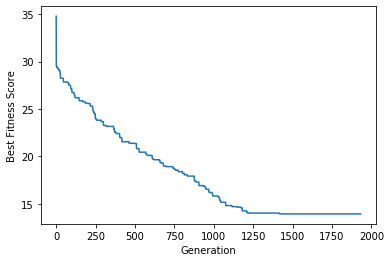

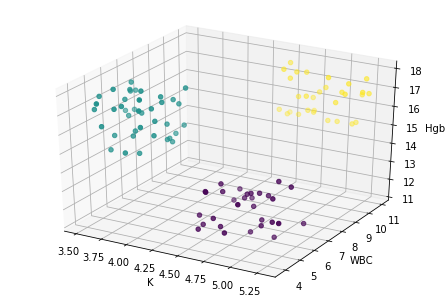

In [0]:
data = EMR3d1

# GA Parameters

#the number of data points = the number of features
number_of_features = data.shape[0]
number_of_solutions = 500
number_of_parents = 250
population_size = (number_of_solutions,number_of_features) 
number_of_generations = 3000
best_outputs = []

# Genesis - 26 is the numerical value of Yud-Hey-Vov-Hey - The name of God related to the creation of the Universe.
np.random.seed(26)
new_population = np.random.randint(low=0, high=K, size=population_size)

#First time to regulate the data
for child in new_population:
    clusters = np.unique(child)
    for c in clusters:
        child[child == c] = np.argwhere(c == clusters)[0]
        
#stopping criteria
NUM_CRITERIA = 50
NUM_ITER = 15

past_fitness = np.zeros(NUM_CRITERIA)
counter = 0

#print("The population of the first generation: ")
#print(new_population)

# Evolution
print ("\nEvolution:")
for generation in range(number_of_generations):
    
    fitness = fitness_function_K(data, new_population)
    print("Generation = ", generation, "\tBest fitness = ",round(1/np.max(fitness),5),"\tNum Classes = ", len(np.unique(new_population[np.argmax(fitness),:])))
    best_outputs.append(1/round(np.max(fitness),5))
    parents = biased_selection_K(new_population, fitness, number_of_parents, replace=True)
    offspring_recombination = recombination_K(parents, offspring_size=(population_size[0]-parents.shape[0], number_of_features))
    offspring_mutation = mutation_K(offspring_recombination,perc_child=0.2)
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation
        
    ## Stopping Criteria
    current_fitness = np.partition(fitness,kth=len(fitness)-NUM_CRITERIA)[-NUM_CRITERIA:]
    #If for NUM_ITER generations, the top NUM_CRITERIA best population don't change, we sterilize the parents.
    if (set(current_fitness).intersection(past_fitness) == set(current_fitness)):
        counter +=1
        if counter == NUM_ITER:
            print("We have reached our stopping criterion")
            break
    else:
        past_fitness = current_fitness
        counter = 0

# Results
print("\nThe population of the last generation: ")
print(new_population)
fitness = fitness_function_K(data, new_population)
best_match_idx = np.where(fitness == np.max(fitness))[0][0]
print(best_match_idx)
print("Best solution: ", new_population[best_match_idx, :])

# Chart
plt.plot(best_outputs)
plt.xlabel("Generation")
plt.ylabel("Best Fitness Score")
plt.show()

# Graph Results 
make_chart(EMR3d1, new_population[best_match_idx,:], variables1)

## Challenge 233: Reconstruct Image (Bonus)
In this part you will attemp to generate an image which is closest to a target image given. 

First we will load the image from a file:


In [0]:
import matplotlib.image as mpimg

img=mpimg.imread('pexels-photo-57905.jpeg')

For simplicity (and running time), we focus on a small part of the image:

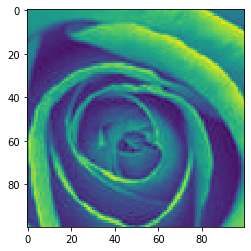

In [0]:
import matplotlib.pyplot as plt
imgplot = plt.imshow(img[100:200,200:300,0])

And we will define this part as out target image to reconstruct:

In [0]:
target = img[100:200,200:300,0]

Your mission is to generate an image starting at random noise. The goal is to get an image as close as possible to the target. Don;t worry if it's still noisy...
FYI: GA are not the best solution for these types of problems ;)
You can use these blog posts to give you ideas:
https://towardsdatascience.com/genetic-algorithm-implementation-in-python-5ab67bb124a6

https://heartbeat.fritz.ai/reproducing-images-using-a-genetic-algorithm-with-python-91fc701ff84

In [0]:
# Your code here